# Background to the Problem

The goal of this problem is to use the Ames Housing Dataset to create a model to predict the sale prices of homes randomly selected from within the original dataset. 

The Ames Housing Dataset was compiled by Dean De Cock in 2011. It is based on all the housing sales that occured in Ames, Iowa during the period from 2006 to 2010. It was created as an alternative to the Boston Housing Dataset and it includes more feature variables (79) that are related to housing price. The original dataset included 2,390 observations. The goal of the creator was to include a wider set of explanatory variables than the original Boston Housing Dataset to allow for more advanced regression techniques to be applied.

The problem itself is based on Kaggle competition to use advanced regression techniques to create a model to predict the sale price of a home. The test data is randomly selected from within the original Ames Housing Dataset. The training dataset used in the Kaggle competition includes 1,460 observations.

In [86]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.metrics import mean_squared_error
import math

# For producing decision tree diagrams.
from IPython.core.display import Image, display
from sklearn.externals.six import StringIO

from dateutil import parser
import datetime

## Housing Price Trends over Time

In order to understand the effect of the overall economy on housing prices within Ames, Iowa during this time period, we look at both the trends within our data and within the country as a whole. We start by looking at trends in our own data set.

The graph below shows the sales prices plotted by year, which was actually in 6 month increments. This graph doesn't seem to show any significant trends in the data over time.

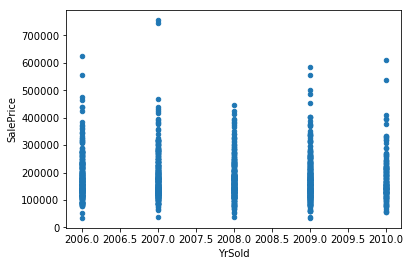

In [87]:
train_data = pd.read_csv("train.csv")
trends_over_time = train_data.plot.scatter(x = 'YrSold', y = 'SalePrice')

Next we look at the data in monthly increments. This visualization also fails to show any significant trends over time.

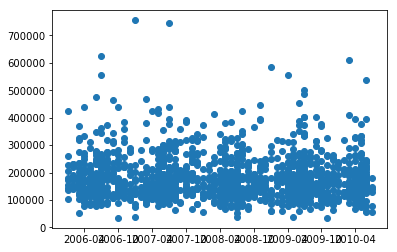

In [60]:
dt = datetime.datetime(year = 2006, month = 2, day = 1)

dates = []

for i in range(len(train_data["YrSold"])):
    dt = datetime.datetime(year = train_data["YrSold"][i], month = train_data["MoSold"][i], day = 1 )
    dates.append(dt)

train_data["DateSold"] = dates

plt.plot_date(x = train_data['DateSold'], y = train_data['SalePrice'], xdate=True, ydate=False, data= train_data)

Next we look at the monthly means and medians of the data to find trends. The graph of the medians by month does seem to show a downward trend towards the start of the national housing crisis.

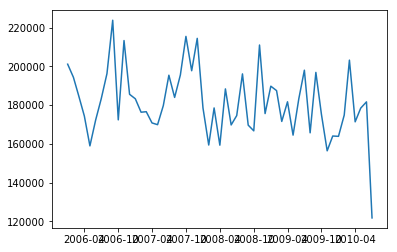

In [73]:
month_averages = train_data.groupby('DateSold')['SalePrice'].mean()
plt.plot(month_averages.index, month_averages)

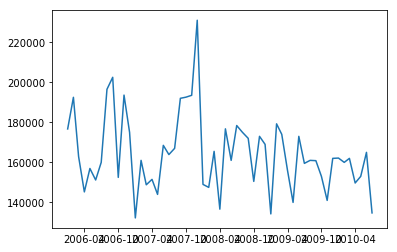

In [74]:
month_medians = train_data.groupby('DateSold')['SalePrice'].median()
plt.plot(month_medians.index, month_medians)

Looking at the medians by month, we do see sharp decline in 2008, which corresponds to the beginning of the housing crisis, and a peak right before the crisis. It is worth noting that the housing crisis may have effected housing prices in this data set. 

Below, we look at data from the Federal Reserve showing the S&P/Case-Schiller National Home Price Index. This helps us understand larger context of housing prices over time.

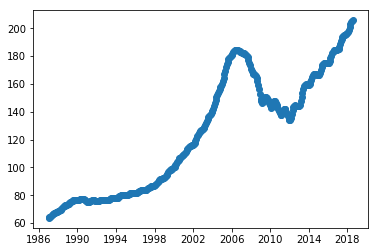

In [77]:
housing_data = pd.read_csv("housing_prices.csv")
plt.plot_date(x = housing_data['DATE'], y = housing_data['CSUSHPINSA'], xdate=True, ydate=False, data= housing_data)


This shows a significant change in housing prices right around the time period we are looking at, from 2006 to 2010. Let's look at this portion of the graph in more detail.

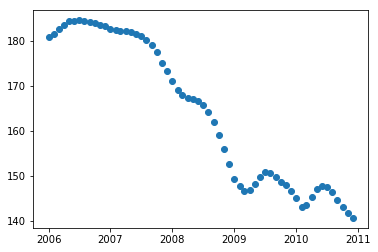

In [85]:
housing_data['DATE'] =  pd.to_datetime(housing_data['DATE'])
housing_data["YEAR"] = housing_data["DATE"].dt.year

housing_data_2006_2010 = housing_data[ (housing_data["YEAR"] >= 2006) & (housing_data["YEAR"] <= 2010)]
plt.plot_date(x = housing_data_2006_2010['DATE'], y = housing_data_2006_2010['CSUSHPINSA'], xdate=True, ydate=False, data= housing_data_2006_2010)


Overall, this analysis suggests that while there were significant trends in the overall US housing market during the 3 year window in with the data was collected, these trends might not have a significant impact on the data in our dataset. However, it is still worth considering how the economic climate overall would affect housing prices.

## Distribution of Sale Price Variable

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119522c50>]], dtype=object)

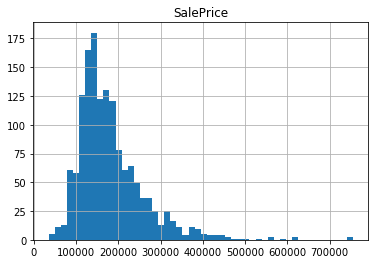

In [2]:
train_data = pd.read_csv("train.csv")
train_data.hist("SalePrice", bins = 50)
#here is a histogram of the target variable

In [11]:
train_data["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

The distribution of the target variable above shows a right-hand skew with a few very large outliers. This initial display suggests that it might be possible to exclude some of the more expensive homes from the training data set, or to possibly create a model that makes different predictions based on whether the home falls into the average range or not.

We can also look at the log of the sales prices to see how this changes the distribution of the target variable.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d5defd0>]], dtype=object)

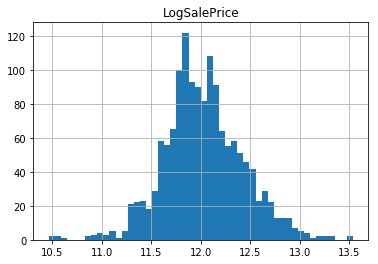

In [12]:
train_data["LogSalePrice"] = np.log(train_data["SalePrice"])
train_data.hist("LogSalePrice", bins = 50)

This produces a more normally distributed set of data. This makes our highly skewed distribution less skewed and allows our sale price data to meet the assumptions of inferential statistics and linear regression.

## Key Variables of Interest

Initially, we can use the correlation matrix to identify some key numerical variables of interest. 

In [20]:
corr_matrix = train_data.corr()
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
totalSF          0.716883
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr

This yields a list of the top 10 most important feature variables to be: Overall Quality, Gross Living Area, Garage Area (and Garage Cars which is closely correlated to Garage Area), Total Basement Square Feet, First Floor Square Feet, the number of Full Bathrooms, the Total Rooms Above Ground, the Year Built and the year remodel was added. 

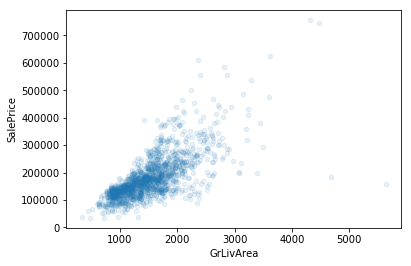

In [19]:
train_data.plot(kind="scatter", x="GrLivArea", y="SalePrice", alpha=0.1)

There are also important categorical variables of interest. 

In [22]:
train_data["Neighborhood"].describe()
train_data["Neighborhood"].unique()
train_data["Neighborhood"].value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

In [ ]:
#How do we look at the usefulness of this variable? How to determine which categorical variables are most relevant? 
#Turn them into dummy variables 

In [90]:
df_neighborhoods = pd.get_dummies(train_data["Neighborhood"])
train_data = pd.concat([train_data, df_neighborhoods], axis=1)
train_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities',
       ...
       'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW',
       'Somerst', 'StoneBr', 'Timber', 'Veenker'],
      dtype='object', length=131)

In [91]:
corr_matrix = train_data.corr()
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
NridgHt          0.402149
NridgHt          0.402149
BsmtFinSF1       0.386420
LotFrontage      0.351799
NoRidge          0.330424
NoRidge          0.330424
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
StoneBr          0.215363
StoneBr          0.215363
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
                   ...   
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
NPkVill         -0.037910
NPkVill         -0.037910
Mitchel         -0.057845
Mitchel     

## Interpretability vs Accuracy

The goal of the Kaggle competiion is to create the most accurate model for predicting the sales price of the testing data. The model that produces the most accurate predictions might not necessarily be the most user-friendly or interpretable model for people actually seeking to use the model in the real world. For instance, real estate brokers or home buyers might be interested in a model that provided less accuracy in terms of exact predictions but more interpretability in terms of using it to make real-time decisions about how much to offer for a given home.

An ideal solution to this problem would not only involve predicting future home prices, which would thus involve weighting recent sales more heavily than older sales, but would also involve various tiers of interpretability for different use cases. For instance, for lay-person home buyers or sellers trying to estimate the value of home, a very interpretable model with fewer included features would be more useful. However, for real estate professionals such as agents or developers, a more accurate model might be worth the additional computing power needed because these decision makers might have access to more resources.

In [ ]:
#what are the specific use cases that different stake-holders might use?
#what are the different scenarios where people might use this model?

# Problem Formulation

This problem is asking us to predict the sale prices of homes that are randomly distributed within the dataset in terms of time. It is not asking to predict the sales prices for homes that will be sold in the future. In this way, the problem is not actually a useful real-world problem to solve. It isn't that useful to predict the sales prices of homes that have already been sold; a useful model would predict the prices of homes that will be sold in the future. In order to create a model that would make these future home price predictions, we would possibly need to exclude or weight differently the more recent data in our training set because we would want the recent data to play a bigger role in training the model.

There are other problems that we could solve using this data set that might be more relevant to real world deciscion makers. For instance, real estate developers might be interested in a model that could predict whether a given home could be flipped for profit. This kind of model would essentially be a classification problem--a given home (or lot) would be classified either as worth buying or not worth buying.

People in the real estate industry spend a lot of time considering "comps" which are comparable properties or homes that they could use to estimate the market value of a home. An interesting reformulation of this problem would be to consider a model that uses clustering and filtering so that homes are only compared to similar homes based on key factors, such as the neighborhood, the location within the neighborhood (i.e. corner lot or on a quiet street), the size of the home and the year it was built. 

Another question that interested parties would consider would be whether or not the home will increase in value, which could also be related to a classification problem with the goal of classifying properties as worth buying to flip or not. 

Additionally, real estate agents or home buyers might want to predict whether a home will sell for more or less than the asking price. This also potentially becomes a classification problem: the homes could be classified as either over-valued or under-valued based on their asking price. This tool could also be used by real-estate agents and sellers looking to set the asking price of a home. Additionally, it would allow for research into whether homes that are under-valued or over-valued end up selling for more or less which would be relevant to sellers who always want to know the best price to ask for a home in order to end up with the best sale price. 

There would be several key variables to be added to the dataset that would make these questions more answerable. First, more specific time information about home sales would be helpful. The current dataset only offers information to the month, not the day. Second, more specific information about the location would be helpful--we don't know which houses are on corner lots, or busy streets or quiet cul-de-sacs. This additional feature would allow for more analysis of the quality of the home's location.

Finally, more information about larger economic trends would be helpful. While it is impossible to predict the future, trends in other economic indicators could have predictive value for future home prices. A model that was able to accurately predict future home prices would need to evaluate the predictive value of various



#is this house a good buy? will it increase in value? taking a lot at "comps"
#how does the asking price compare to comparable homes? this is like a clustering problem
Location Location Location

#should i bid over or under the asking price? how does the asking price relate to final sales price?

#how could the data we have be massaged into data that we could use to answer these questions?

#look at the recent increase/decrease of housing prices (how are housing prices changes over time within the recent time period?)
